# Podcast Reviews Project

# Objectives

The objective for this project is two-fold:
- Explore sample and its features utilising typical EDA methods.
- Raise hypotheses about the broader population, which the sample represents, and establish possibly significant results.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels.api as sm
from typing import Tuple, List

## Tables

In [2]:
with sqlite3.connect('database.sqlite') as con:
    print(list(pd.read_sql_query(
        "select name from sqlite_master where type='table';", con)['name']))

['runs', 'podcasts', 'categories', 'reviews']


## Columns

In [3]:
print(*list(f'{i} table: {list(pd.read_sql_query(f"select * from {i} limit 0", con).columns)}'
        for i in 'runs, podcasts, categories, reviews'.split(',')), sep='\n')

runs table: ['run_at', 'max_rowid', 'reviews_added']
 podcasts table: ['podcast_id', 'itunes_id', 'slug', 'itunes_url', 'title']
 categories table: ['podcast_id', 'category']
 reviews table: ['podcast_id', 'title', 'content', 'rating', 'author_id', 'created_at']


## Reading the Data

In [4]:
categories = pd.read_sql_query(
    """select *
    from categories
    """, con)

In [5]:
df = pd.read_sql_query(
    """select 
    r.podcast_id, r.title review_title, r.content, r.rating, r.created_at,
    p.title podcast_title    
    from reviews r
    join podcasts p
    on r.podcast_id = p.podcast_id
    """, con)

In [6]:
df['created_at'][~df['created_at'].apply(lambda x: x.isascii())]

1113461    ٢٠٢٠-١٢-٢٤T٠٨:٢٦:٣٦-07:00
1113462    ٢٠٢٠-١٢-٢٤T١١:٥٥:٠٨-07:00
Name: created_at, dtype: object

These two dates contain eastern arabic numerals.

In [7]:
def convert_eastern_arabic_to_western_arabic(input_str: str) -> str:
    if not input_str.isascii():  
        arabic_to_western = str.maketrans('٠١٢٣٤٥٦٧٨٩', '0123456789')
        return input_str.translate(arabic_to_western)
    return input_str

In [8]:
df['created_at'] = df['created_at'].apply(convert_eastern_arabic_to_western_arabic)
df['created_at'] = pd.to_datetime(df['created_at'], format='ISO8601')
df['rating'] = df['rating'].astype('float')

In [9]:
df.head(5)

,podcast_id,review_title,content,rating,created_at,podcast_title
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5.0,2018-04-24 12:05:16-07:00,Backstage at Tilles Center
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5.0,2018-05-09 18:14:32-07:00,Backstage at Tilles Center
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1.0,2019-06-11 14:53:39-07:00,TED Talks Daily
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5.0,2018-05-31 13:08:09-07:00,TED Talks Daily
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5.0,2019-06-19 13:56:05-07:00,TED Talks Daily


# Data Validation

## Duplicated Data

In [10]:
df.head(0)

,podcast_id,review_title,content,rating,created_at,podcast_title


In [11]:
duplicated_rows = df[df[['review_title', 'content', 'rating', 'podcast_title']].duplicated()]
len(duplicated_rows)

1516

In [12]:
df.drop(duplicated_rows.index, inplace=True)

## Outliers

There are no numeric features in this dataset where possible outliers would need to be handled.

## Missing Values

In [13]:
df.isna().any().any()

False

# EDA

## Aggregating Categories

There are categories that contain multiple sub-categories as well as multiple category entries which have the same podcast id, therefore some aggregation needs to be done.

In [14]:
unique_categories = pd.Series(categories['category'].unique())
print(list(unique_categories))

['arts', 'arts-performing-arts', 'music', 'arts-design', 'education', 'society-culture', 'arts-visual-arts', 'leisure', 'leisure-hobbies', 'arts-books', 'technology', 'society-culture-personal-journals', 'society-culture-relationships', 'fiction', 'fiction-science-fiction', 'arts-food', 'education-language-learning', 'fiction-drama', 'true-crime', 'health-fitness', 'health-fitness-nutrition', 'history', 'comedy', 'arts-fashion-beauty', 'tv-film', 'society-culture-places-travel', 'comedy-comedy-interviews', 'kids-family', 'health-fitness-mental-health', 'religion-spirituality', 'business', 'news', 'news-business-news', 'education-courses', 'society-culture-philosophy', 'leisure-video-games', 'tv-film-film-reviews', 'leisure-games', 'spirituality', 'tv-film-film-history', 'business-careers', 'business-entrepreneurship', 'science', 'science-earth-sciences', 'comedy-improv', 'tv-film-tv-reviews', 'health-fitness-sexuality', 'news-politics', 'leisure-home-garden', 'leisure-animation-manga',

In [15]:
broader_cat_list = ['comedy', 'business', 'spirituality', 'sports',
                    'health', 'arts', 'music', 'education', 'science', 'kids', 'technology', 'news', 'culture', 'film', 'leisure']
pattern = '|'.join(broader_cat_list)

In [16]:
unique_categories[~unique_categories.str.contains(pattern)]

13           fiction
17     fiction-drama
18        true-crime
21           history
51      christianity
52        government
54          hinduism
75           judaism
76          religion
90             islam
102         buddhism
dtype: object

In [17]:
def aggregate_categories(entry: str) -> str:
    for comparison in ['fiction', 'drama', 'true-crime']:
        if comparison in entry:   
            return 'film'
    if 'history' in entry:
        return 'education'
    elif entry.endswith('ism') or ('religion' in entry 
           or 'islam' in entry 
           or 'christianity' in entry):
        return 'spirituality'
    elif 'government' in entry:
        return 'news'
    else:
        for i in broader_cat_list:
            if i in entry:
                return i

In [18]:
categories['aggregated_category'] = categories['category'].apply(aggregate_categories)
categories['aggregated_category'].isna().any()

False

In [19]:
categories.drop('category', axis=1, inplace=True)

In [20]:
len(categories) - len(categories.drop_duplicates())

70871

In [21]:
categories.drop_duplicates(inplace=True)

In [22]:
categories

,podcast_id,aggregated_category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
5,ad4f2bf69c72b8db75978423c25f379e,education
6,ad4f2bf69c72b8db75978423c25f379e,culture
...,...,...
212366,e10afe12558725e31e08f3e5ebe53c5f,sports
212367,da8331a8fbbba6fe1e2653f2fa86e168,news
212369,da8331a8fbbba6fe1e2653f2fa86e168,science
212370,d41b3b7b2413fcf202d8bef1512554dc,spirituality


Now that the categories are aggregated and deduped, it's time to merge them into the main DataFrame.

In [23]:
df_w_categories = df.merge(categories, on='podcast_id', validate='many_to_many')

In [24]:
df_w_categories.head(5)

,podcast_id,review_title,content,rating,created_at,podcast_title,aggregated_category
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5.0,2018-04-24 12:05:16-07:00,Backstage at Tilles Center,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5.0,2018-04-24 12:05:16-07:00,Backstage at Tilles Center,music
2,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5.0,2018-05-09 18:14:32-07:00,Backstage at Tilles Center,arts
3,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5.0,2018-05-09 18:14:32-07:00,Backstage at Tilles Center,music
4,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1.0,2019-06-11 14:53:39-07:00,TED Talks Daily,arts


Some podcasts had multiple categories assigned to them.

## Number of Podcasts

In [25]:
len(df.podcast_id.unique())

110023

## Overall Rating Distribution

How are the ratings distributed in this sample?

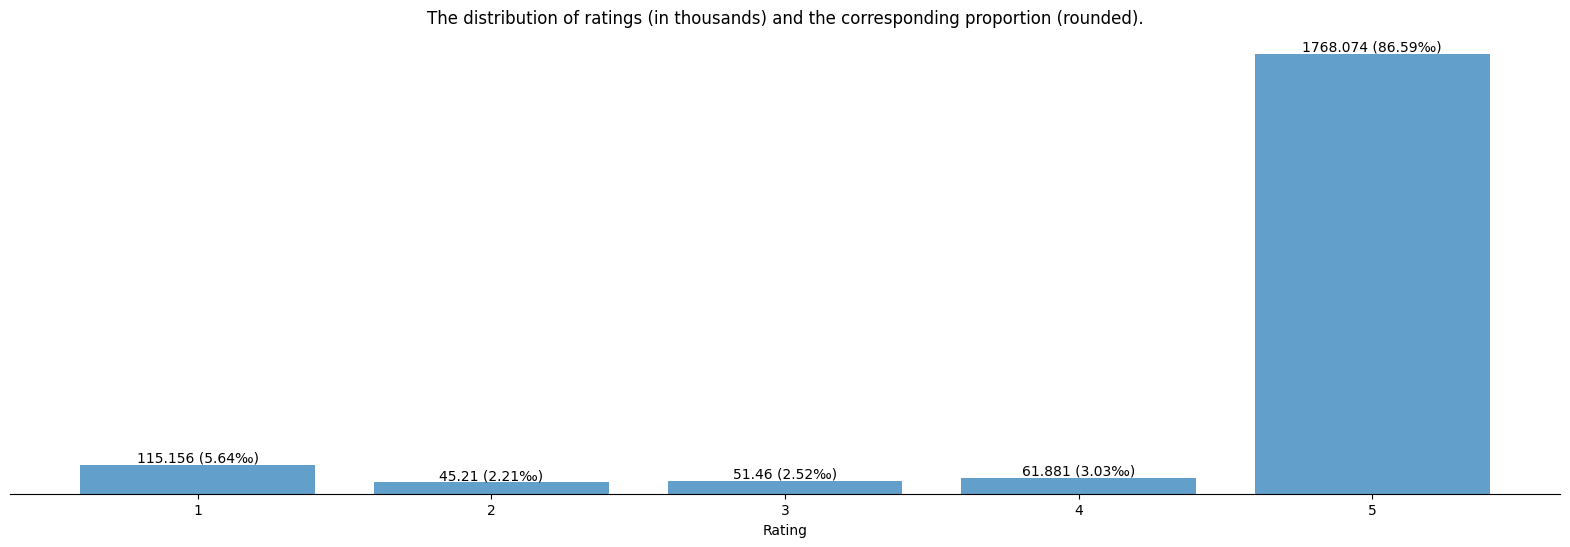

In [26]:
fig, ax = plt.subplots(figsize=(20,6))
bars = ax.bar(df.rating.value_counts().index,
        df.rating.value_counts().values, alpha=0.7)
ax.spines[['top','left','right']].set_visible(False)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_locator(plt.NullLocator())
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval/1E3} ({round((yval/len(df))*100, 2)}‰)',
            verticalalignment='bottom',  
            ha='center')
ax.set_title('The distribution of ratings (in thousands) and the corresponding proportion (rounded).')
ax.set_xlabel('Rating');

The ratings in this sample are predominantly positive.

## Mean Rating Across Time

How did the mean rating evolve over time?

In [27]:
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year

In [28]:
df.created_at.min(), df.created_at.max()

(Timestamp('2005-12-09 21:41:01-0700', tz='UTC-07:00'),
 Timestamp('2023-02-16 08:38:37-0700', tz='UTC-07:00'))

Data for years 2005 and 2023 is incomplete.

In [29]:
grouped = df.groupby(['year','month'], as_index=False)['rating'].mean()
grouped.T

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
year,2005.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,...,2022.000000,2022.000000,2022.00000,2022.000000,2022.000000,2022.000000,2022.000,2022.000000,2023.000000,2023.000000
month,12.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,5.000000,6.000000,7.00000,8.000000,9.000000,10.000000,11.000,12.000000,1.000000,2.000000
rating,4.791667,4.712538,4.753125,4.602888,4.544061,4.566787,4.520737,4.331897,4.577519,4.533074,...,4.525489,4.473339,4.42528,4.478893,4.468159,4.470241,4.439,4.435055,4.453514,4.388344


In [30]:
grouped['date'] = pd.to_datetime(grouped[['year', 'month']].assign(DAY=1))

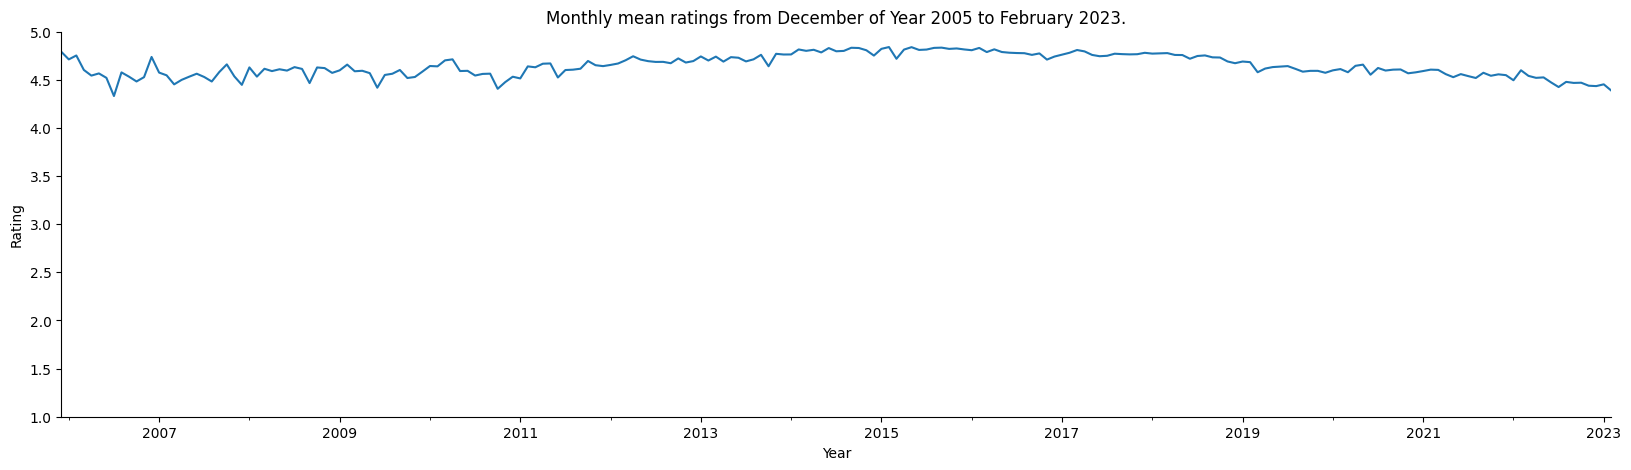

In [31]:
grouped.set_index('date').plot(y='rating',
                               figsize=(20,5), ylim=(1,5), legend=False)
ax = plt.gca()
ax.set_title('Monthly mean ratings from December of Year 2005 to February 2023.')
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Rating')
ax.set_xlabel('Year');

The differences between monthly means within a year tend to decrease. This is probably due to the increasing popularity of podcasts which means a greater amount of total reviews per month, therefore making the jumps between months less volatile.

## Correlation of Rating and Comment Length

Is the length of the comment content related to the rating itself. In other words is large/small comment length predictive of the sentiment expressed by rating.

In [32]:
np.corrcoef(df.rating, df.content.str.len())[1, 0]

-0.09744192231838818

Extreamely weak negative correlation. Likely no specific association.

## Most Rated Categories

Which categories are the most/least rated?

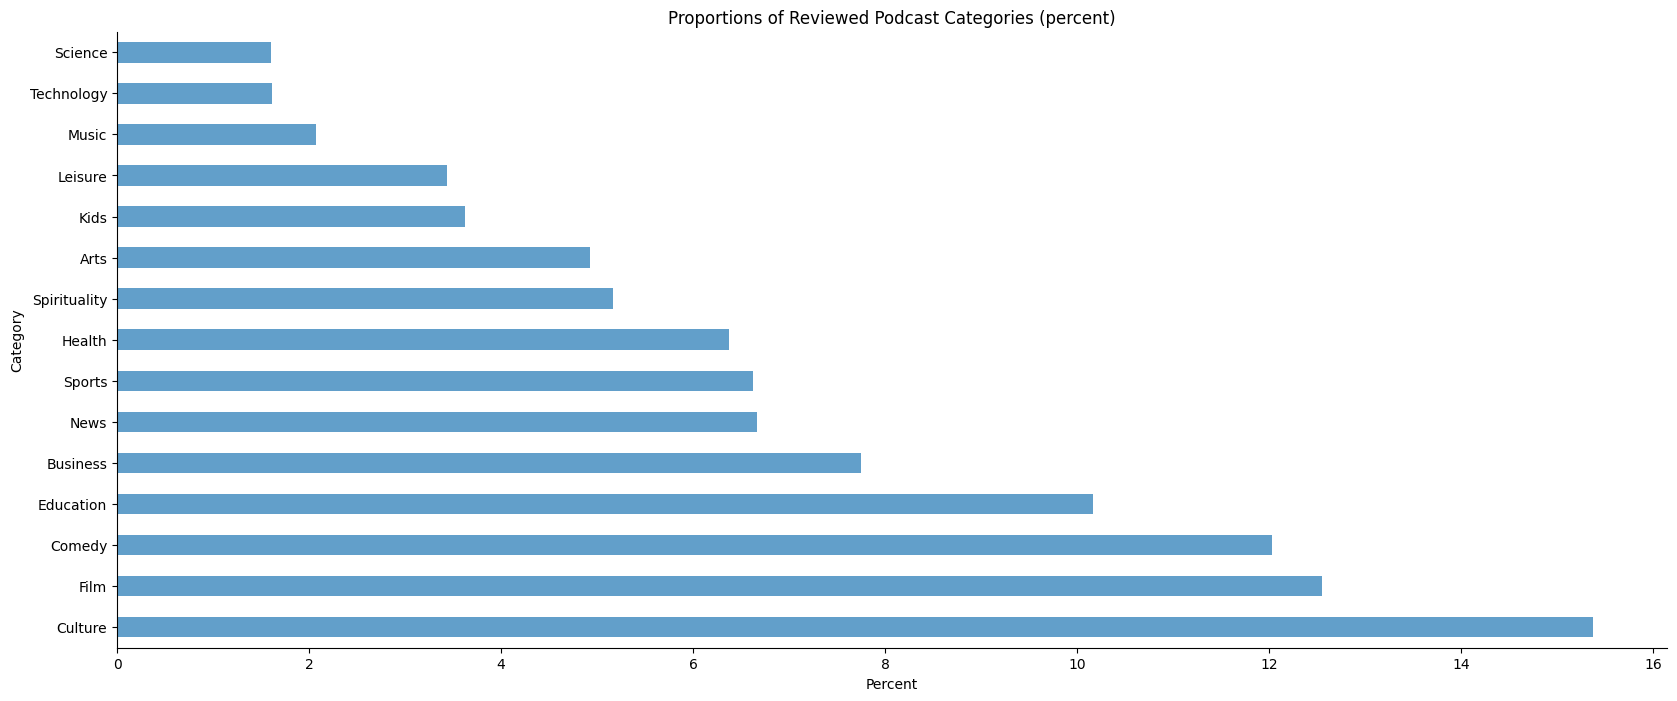

In [33]:
(df_w_categories
 .aggregated_category
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='barh', figsize=(20,8), alpha=0.7)
)
ax = plt.gca()
ax.set_xlabel('Percent')
ax.set_ylabel('Category')
ax.set_title('Proportions of Reviewed Podcast Categories (percent)')
ax.spines[['top','right']].set_visible(False)
ax.set_yticks(ticks=plt.yticks()[0],
labels=[label.get_text().capitalize() for label in ax.get_yticklabels()]);

Culture category seems to be the most reviewed, while Science the least. This is probably due to overall category viewer base.

## Mean Rating per Category

What is the mean rating for each category?

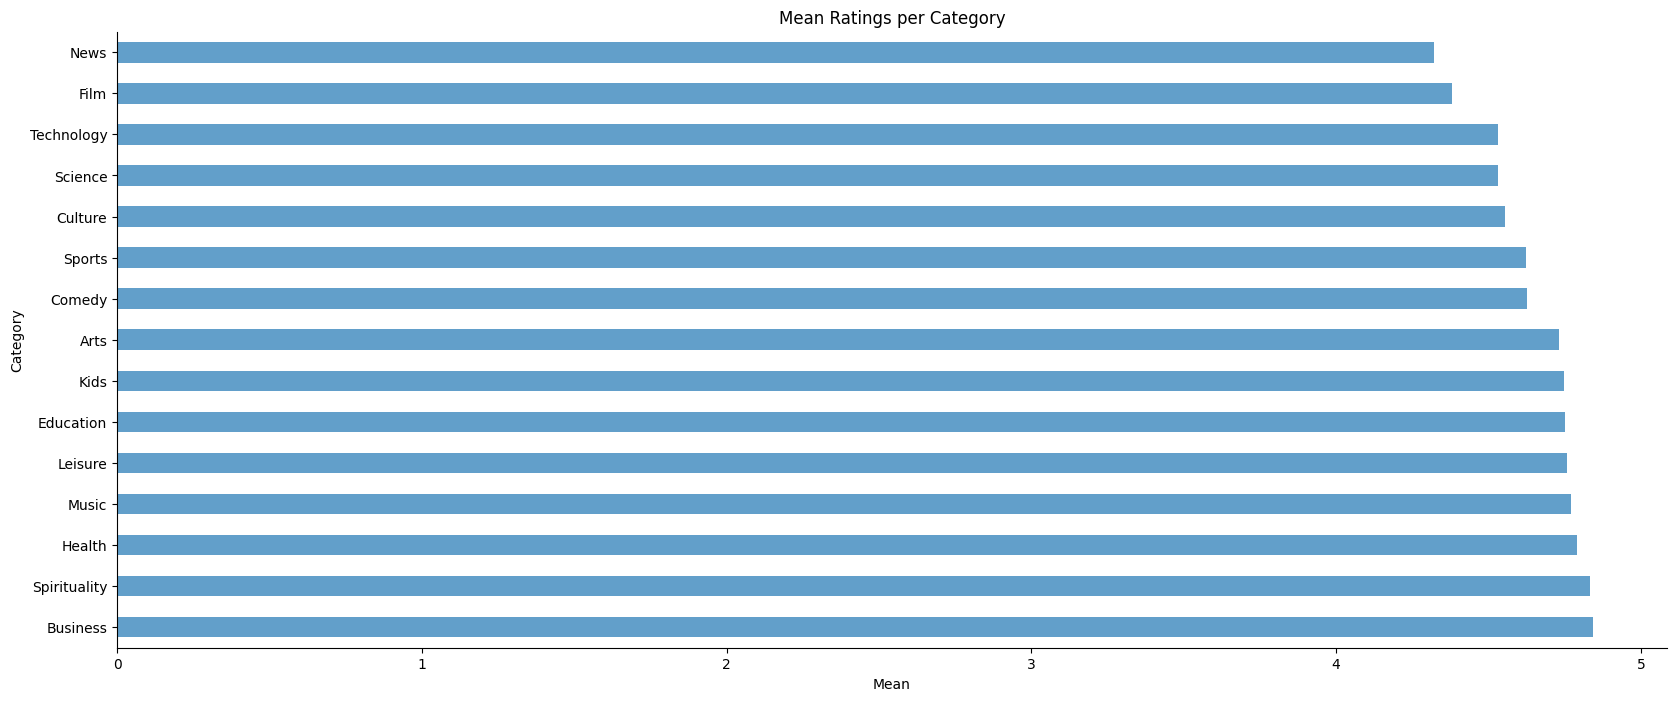

In [34]:
(df_w_categories
 .groupby('aggregated_category')['rating']
 .mean()
 .sort_values(ascending=False)
 .plot(kind='barh', figsize=(20,8), alpha=0.7)
)
ax = plt.gca()
ax.set_xlabel('Mean')
ax.set_ylabel('Category')
ax.set_title('Mean Ratings per Category')
ax.spines[['top','right']].set_visible(False)
ax.set_yticks(ticks=plt.yticks()[0],
labels=[label.get_text().capitalize() for label in ax.get_yticklabels()]);

News category has the lowest mean rating, while, interestingly, the Business category has the highest. In the case of the News category, one likely explanation would be the politically charged polarizing topics often discussed in these podcasts.

## Mean Comment Length per Category

What is the mean comment length given the category?

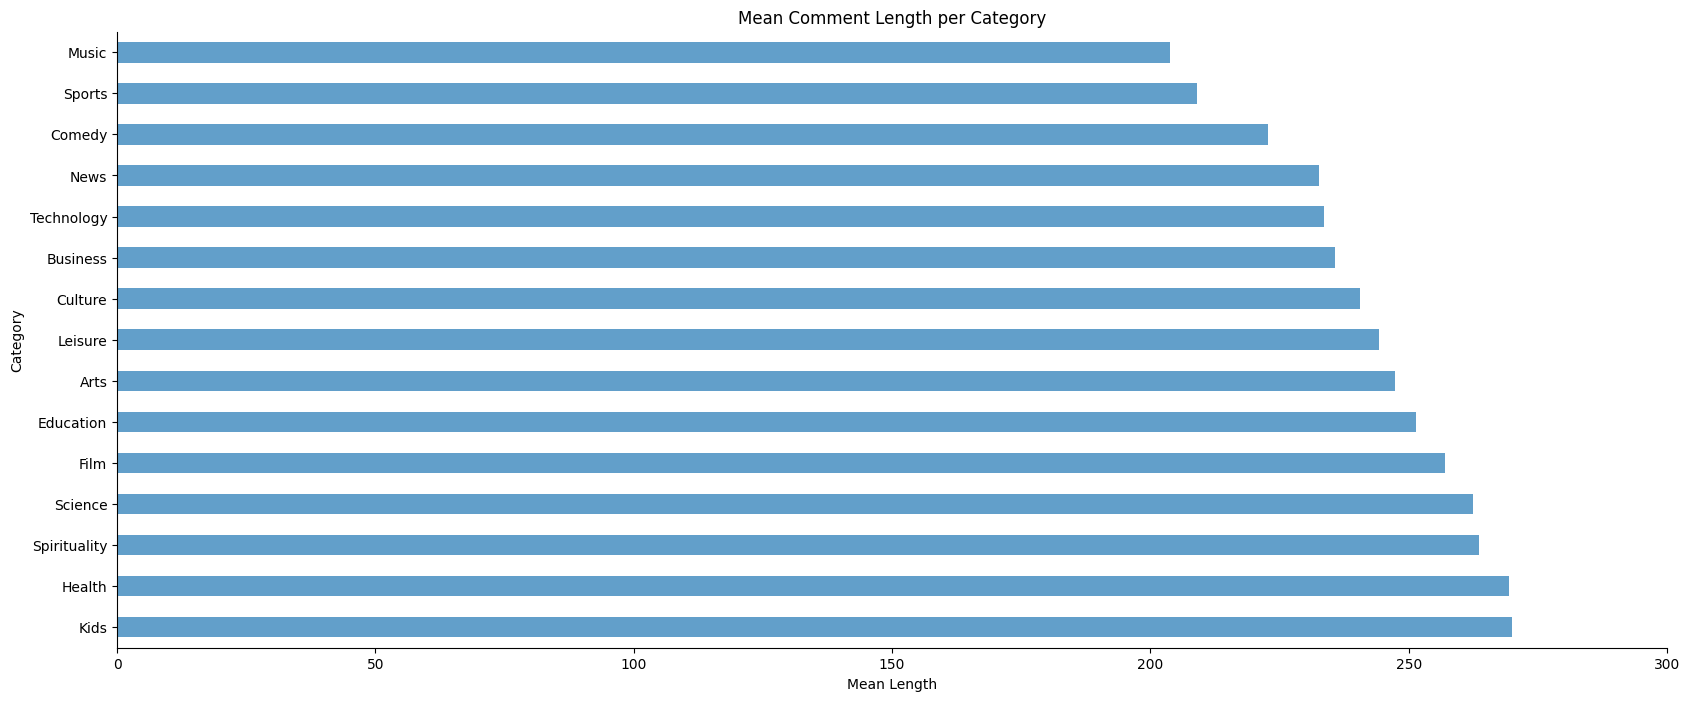

In [35]:
(df_w_categories
 .assign(comment_length=df_w_categories['content'].str.len())
 .groupby('aggregated_category')['comment_length']
 .mean()
 .sort_values(ascending=False)
 .plot(kind='barh', figsize=(20,8), alpha=0.7)
)
ax = plt.gca()
ax.set_xlabel('Mean Length')
ax.set_ylabel('Category')
ax.set_title('Mean Comment Length per Category')
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0,300)
ax.set_yticks(ticks=plt.yticks()[0],
labels=[label.get_text().capitalize() for label in ax.get_yticklabels()]);

Music and Health categories have the largest lengths.

## Most Rated Podcasts

Which of the podcasts have the highest rating activity?

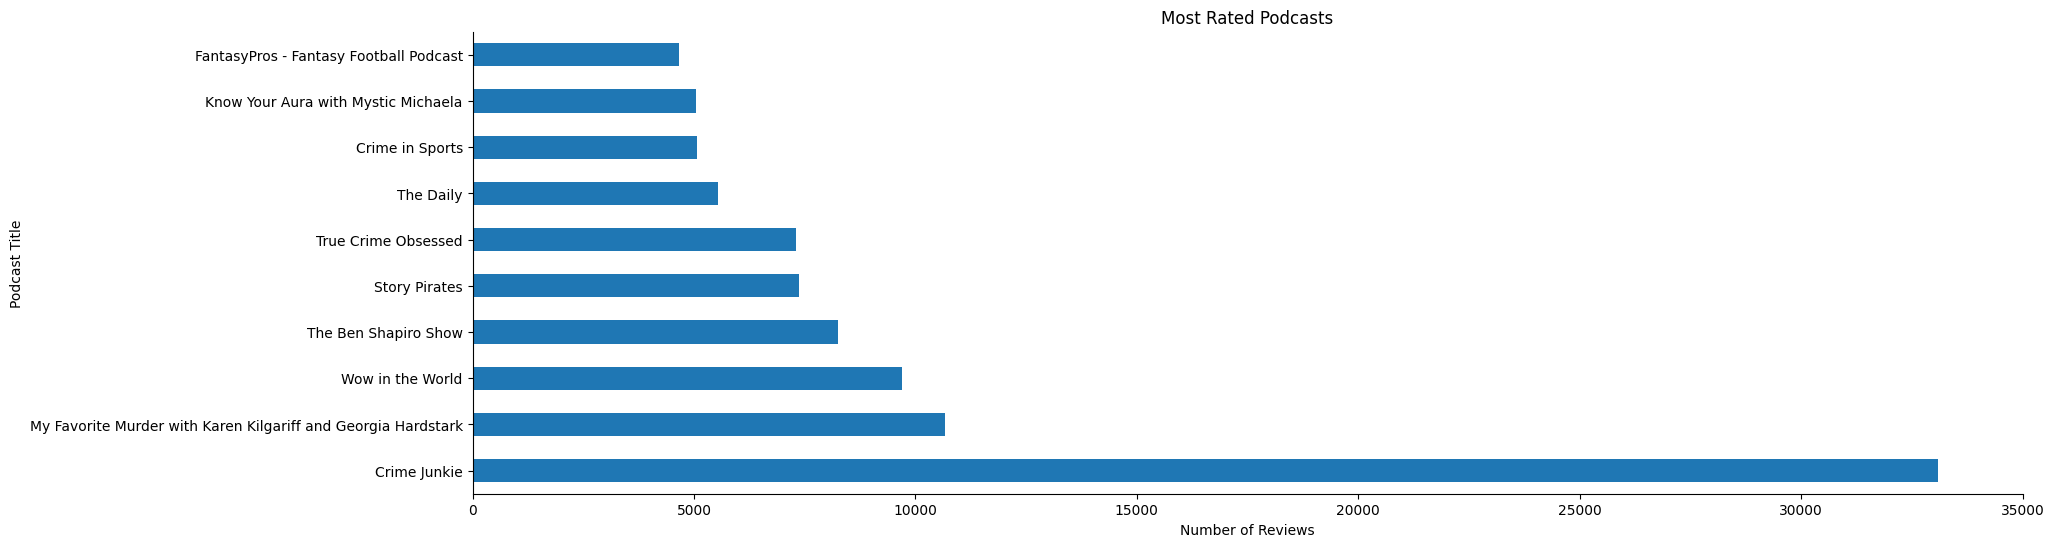

In [36]:
(df
 .groupby('podcast_title')
 .rating
 .count()
 .sort_values(ascending=False)
 .head(10)
 .plot(kind='barh', figsize=(20,6))
)
ax = plt.gca()
ax.set_xlim(0,3.5E4)
ax.set_title('Most Rated Podcasts')
ax.set_ylabel('Podcast Title')
ax.set_xlabel('Number of Reviews')
ax.spines[['top','right']].set_visible(False);

The Crime Junkie podcast has overwhelmingly more reviews posted than the rest of the podcasts.

## Highest/Lowest Rated Popular Podcasts

Assuming that the number of reviews left in this sample correlate with popularity, let's set the threshold of a popular podcast at 1000 reviews.

In [37]:
over_1000_review_means = (
 df
 .groupby('podcast_title')
 .filter(lambda x: len(x) >= 1_000)
 .groupby('podcast_title')
 .rating
 .mean()
 .sort_values(ascending=False)
)

In [38]:
pd.DataFrame(over_1000_review_means.head(10)).T

podcast_title,Sassy Lashes,Shawn Ryan Show,Daebak Show w/ Eric Nam,Know Your Aura with Mystic Michaela,Biceps After Babies Radio,BASS TALK LIVE,Andrea Savage: A Grown-Up Woman #buttholes,Ali on the Run Show,Fantastic Geeks,Ghostrunners
rating,4.99305,4.990962,4.984244,4.983574,4.981279,4.960585,4.957736,4.955224,4.951415,4.950181


In [39]:
pd.DataFrame(over_1000_review_means.tail(10)).T

podcast_title,Morning Joe,The Argument,Radiolab,The Daily,Pod Save America,Off The Vine with Kaitlyn Bristowe,Fantasy Focus Football,Cold Case Files,The Fighter & The Kid,The Ben and Ashley I Almost Famous Podcast
rating,3.360859,3.35089,3.346952,3.343874,3.288116,3.286064,3.273579,2.966284,2.764513,2.762897


Sassy Lashes podcast has the highest mean rating while The Ben and Ashley I Almost Famous Podcast has the lowest.

# Inference

## 5 &#x2605; Ratings

What population proportion of all podcasts(years 2005-2023) get rated 5 stars?.<br>
**Population**: All podcasts(years 2005-2023).

### Assumptions for a Single Population Propotion Confidence Interval:

- <div style="line-height:1;">Sample Size - There should be a "large enough" sample size. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:2.7;">Simple Random Sample <span style="color:red; font-size:15px;">&#10060;</span></div>

In [40]:
def binomial_ci(confidence, p_hat, n):
    z_score = stats.norm.interval(confidence)[1]
    rhs = z_score * np.sqrt(p_hat*(1-p_hat)/n)
    ci = [p_hat - rhs, p_hat + rhs]
    return ci

In [41]:
p_hat_rating_5 = len(df['rating'][df['rating'] == 5]) / len(df['rating'])
n_rating = len(df['rating'])
p_hat_rating_5

0.8659469355430381

In [42]:
binomial_ci(0.95, p_hat_rating_5, n_rating)

[0.8654796013853436, 0.8664142697007327]

Based on the sample of 2041781 podcast reviews, with 95% confidence, the population proportion of all podcast reviews(years 2005-2023) which hold a 5 star rating, lie between 0.8654796013853436 and 0.8664142697007327. However, it must be noted that the assumption of a simple random sample for this confidence interval is violated since the data was not sampled at random.

## 1 &#x2605; Rating

What population proportion of all podcasts(years 2005-2023) get rated 1 stars?.<br>
**Population**: All podcasts(years 2005-2023).

### Assumptions for a Single Population Propotion Confidence Interval:

- <div style="line-height:1;">Sample Size - There should be a "large enough" sample size. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:2.7;">Simple Random Sample <span style="color:red; font-size:15px;">&#10060;</span></div>

What proportion of all podcasts (years 2005-2023) get rated 1 star?

In [43]:
p_hat_rating_1 = len(df['rating'][df['rating'] == 1]) / len(df['rating'])
p_hat_rating_1

0.05639978038780849

In [44]:
binomial_ci(0.95, p_hat_rating_1, n_rating)

[0.05608335141964617, 0.05671620935597081]

Based on the sample of 2041781 podcast reviews, with 95% confidence, the population proportion of all podcast reviews(years 2005-2023) which hold a 1 star rating, lie between 0.056<span style="color:red">0833</span>5141964617 and 0.056<span style="color:red">7162</span>0935597081. However, it must be noted that the assumption of a simple random sample for this confidence interval is violated since the data was not sampled at random.

## Mean Rating for All Reviews

What is the population mean for all podcasts(years 2005-2023).<br>
**Population**: All podcasts(years 2005-2023).

### Assumptions For Single Population Mean Confidence Interval:

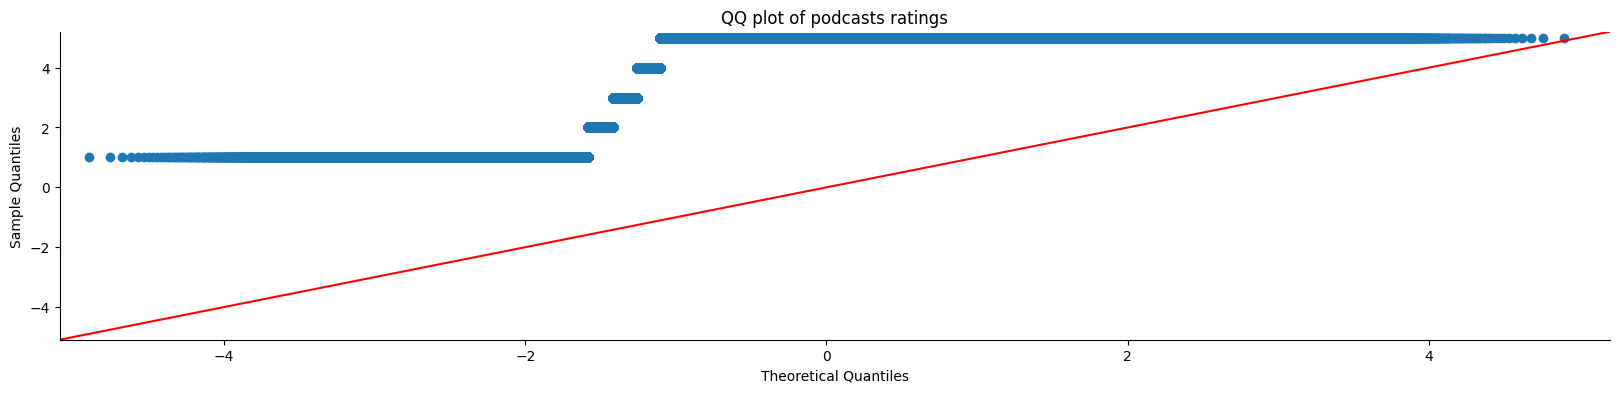

In [45]:
fig = sm.qqplot(df['rating'], line ='45')
fig.set_size_inches(20, 4)
ax = plt.gca()
ax.spines[['top','right']].set_visible(False)
ax.set_title('QQ plot of podcasts ratings');

The distribution is non-normal and heavily left-skewed. Since the sample size is very large we should be able to rely on CLT.

- <div style="line-height:1;">Sample size - There should be a "large enough" sample size. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:2.7;">Normality (less critical with large sample size). <span style="color:red; font-size:15px;">&#10060;</span></div></div>
- <div style="line-height:1.4;">Simple random sample. <span style="color:red; font-size:15px;">&#10060;</span></div>

What is the population rating mean of all podcasts (years 2005-2023)?

In [46]:
def mean_ci(confidence, x_bar, sigma, n):
    z_score = stats.norm.interval(confidence)[1]
    sigma_over_root_n = sigma / np.sqrt(n)
    ci = [x_bar - z_score * sigma_over_root_n, x_bar + z_score * sigma_over_root_n]
    return ci

In [47]:
rating_stats = df.rating.describe()

In [48]:
mean_ci(0.95, rating_stats['mean'], rating_stats['std'], rating_stats['count'])

[4.625824659124836, 4.628693822534068]

Based on the sample of 2041781 podcast reviews, with 95% confidence, the population mean of all podcast reviews (years 2005-2023), lies between 4.62<span style="color:red">5824</span>659124836 and 4.62<span style="color:red">8693</span>822534068. However, it must be noted that the assumption of a simple random sample for this confidence interval is violated since the data was not sampled at random.

### Bootstrapped CI

Because the normality assumption was violated for the sake of a robust result in addition to the parametric confidence interval we will do a resampled one where we don't need to assume normality.

In [49]:
bootstrapped_mean_ci = stats.bootstrap((df['rating'].values,), np.mean, n_resamples=1000, method='basic')

In [50]:
bootstrapped_mean_ci.confidence_interval

ConfidenceInterval(low=4.6258893583591965, high=4.628709567774409)

The bootstrapped interval with only 1000 resamples already gives very close results to the parametric one, therefore confirming that everything went fine.

In [86]:
def mean_ci_boot(data:List[float], loops:int, conf:float) -> Tuple[float, float]:
    sample_dist = np.array([])
    for _ in range(loops):
        sampled_data = np.random.choice(data,
        size=len(data), replace=True)
        sample_mean = np.mean(sampled_data)
        sample_dist = np.append(sample_dist, sample_mean)
        lower_percentile = (100 - conf) / 2
        upper_percentile = (100 + conf) / 2
    return (np.percentile(sample_dist, lower_percentile),
            np.percentile(sample_dist, upper_percentile))

In [82]:
mean_ci_boot(df['rating'].values,2000,95)

(4.625790914892439, 4.628720440634916)

## Mean Rating in Respect to Year

In [ ]:
for i in range(df.created_at.dt.year.min(), df.created_at.dt.year.max() +1):
    print(df[df.created_at.dt.year==i]['created_at'].dt.date.min(),'to',
          df[df.created_at.dt.year==i]['created_at'].dt.date.max())

Data for years 2005, and 2023 is missing at large, therefore will not be used.

Sample sizes:

In [ ]:
pd.DataFrame(df.groupby('year')['rating'].count()[1:-1]).T

### Testing for Difference

Are there statistically significant differences between population mean ratings for each year?<br>
**Populations**: yearly groups of all podcasts(years 2006-2022).

In [ ]:
grouped = df[(df['year'] > 2005) & (df['year'] < 2023)].groupby('year')['rating']
yearly_groups = [group.to_numpy() for _, group in grouped]

Similar sample sizes and lot of other assumptions must be met to perform ANOVA test on all years from 2006 to 2022. So the non-parametric equivalent Kruskal-Wallis test will be used which compares the rank means.

### Assumptions For the Kruskal-Wallice/Dunn's Test:

- <div style="line-height:1;">Ordinal Variables - the variable in question should be ordinal or continuous, i.e., have some kind of hierarchy to them.
    <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:1;">Independence - each group should be independent from the others. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:1;">Sample Size - There should be a "large enough" sample size. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:2.7;">Simple Random Sample <span style="color:red; font-size:15px;">&#10060;</span></div>

### Hypotheses/Significance level:

$$H_0: \mu_1 =\mu_2=\mu_3...\ (rank\ means)$$
$$H_a: \mu_1 \neq \mu_2 \neq \mu_3...\ (rank\ means)$$
$$\alpha=0.05$$

In [ ]:
kruskal_result = stats.kruskal(*yearly_groups)

In [ ]:
print(f'\nH-Statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}\n')

Based on our sample and our p-value, we reject the null hypothesis. In this case, we conclude that there are significant differences between the population rating distributions for years from the year 2006 to 2022. However, it must be noted that the assumption of a simple random sample for this test is violated since the data was not sampled at random.

### Post-hoc Testing

Which pairs of yearly mean ratings differ significantly?\
**Populations**: yearly groups of all podcasts(years 2006-2022).\
The non parametric Dunn's test will be used. This test follows the same assumptions as the Kruskal-Wallis test. The p-value is adjusted according to the conservative Bonferronni correction method.\
$$H_0: \mu_1 - \mu_2 = 0\ (rank\ means)$$
$$H_a: \mu_1 - \mu_2 \neq 0\ (rank\ means)$$
$$\alpha = 0.05\ (for\ all\ pairs\ (adjusted))$$

In [ ]:
dunn = sp.posthoc_dunn(df[(df['year'] > 2005) & (df['year'] < 2023)], 'rating', 'year', 'bonferroni')
dunn.head(5)

Filtering the tests to check for difference in ratings between preceeding and suceeding years:

In [ ]:
print(*[f'group_1: {year}  group_2: {year+1}  reject_null?: {value}\n'
        for year, value in zip(dunn.index[:-1], np.diag(dunn, k=1) < 0.05)])

Based on our sample and our p-value:
- For years 2008, 2011, 2012, 2013, 2014, 2016, 2018, 2019, 2021, 2022, we reject the null hypothesis. In this case, we conclude that there are significant differences between the population rating distributions for these years when compared to the previous year.
- For years 2007, 2009, 2010, 2015, 2017, 2020 we dont reject the null hypothesis. In this case, we conclude that there are no significant differences between the population rating distributions for these years when compared to the previous year.

However, it must be noted that the assumption of a simple random sample for this test is violated since the data was not sampled at random.

## Difference in Mean Ratings Before and After the COVID-19 Pandemic Lockdown Period.

Is there a significant difference in mean ratings between the before and the after of COVID-19 lockdown. Since most countries implemented lockdowns from April to July of 2020, the cut-off point will be there. The mean rating of this period will be compared with that of the same period of the prior year.\
**Populations**: All podcasts(April 1st to July 1st years 2019 and 2020).

In [ ]:
ratings_april_july_2019 = df['rating'][(df['created_at'] > '2019-04-01') & (df['created_at'] < '2019-07-01')]
ratings_april_july_2020 = df['rating'][(df['created_at'] > '2020-04-01') & (df['created_at'] < '2020-07-01')]

### Assumptions for the Mean Difference t-test

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8))

sm.qqplot(ratings_april_july_2019, line='45', ax=axs[0])
axs[0].set_title('QQ Plot for podcasts ratings from April to July of year 2019')
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].set_ylim(-5, 6)

sm.qqplot(ratings_april_july_2020, line='45', ax=axs[1])
axs[1].set_title('QQ Plot for podcasts ratings from April to July of year 2020')
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_ylim(-5, 6)

plt.tight_layout();

Both distributions are non-normal and heavily left-skewed. Since the sample size are large we should be able to rely on CLT.

- <div style="line-height:1;">Independence - each group should be independent from the others. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:1;">Sample Size - There should be a "large enough" sample size. <span style="color:green; font-size:30px;">&#10004;</span></div>
- <div style="line-height:2.7;">Both populations should be approximately normally distributed(less critical with a larger sample size). <span style="color:red; font-size:15px;">&#10060;</span></div>
- <div style="line-height:1.4;">Simple Random Sample. <span style="color:red; font-size:15px;">&#10060;</span></div>

### Variance

In [ ]:
covid_df = pd.concat((pd.DataFrame(ratings_april_july_2019).assign(year = '2019'), 
          pd.DataFrame(ratings_april_july_2020).assign(year = '2020')), 
          ignore_index=True)
assert len(covid_df) == len(ratings_april_july_2019) + len(ratings_april_july_2020)

In [ ]:
sns.violinplot(data=covid_df, x="year", y="rating")
plt.gcf().set_size_inches(20, 3)
ax = plt.gca()
ax.spines[['top','right']].set_visible(False)
ax.set_title('Violin plots of podcast ratings (April-July years 2019 and 2020)')
ax.set_ylim(1,6);

In [ ]:
np.power(ratings_april_july_2019.std(), 2), np.power(ratings_april_july_2020.std(), 2)

Both populations seem to have very similar variance, therefore will be assumed equal.

$$
H_0: \mu_1 - \mu_2 = 0
$$
$$
H_a: \mu_1 - \mu_2 \neq 0
$$
$$
\alpha = 0.05
$$

In [ ]:
t_statistic, p_value = stats.ttest_ind(ratings_april_july_2019, ratings_april_july_2020, equal_var=True)

In [ ]:
t_statistic, p_value

Based on our sample and our p-value, we reject the null hypothesis. In this case, we conclude that there is a significant difference between the population mean rating difference for periods from April to July of years 2019 and 2020. However, it must be noted that the assumption of a simple random sample for this test is violated since the data was not sampled at random.

### Bootstrapped Significance Test

For the sake of robustness let's do a non-parametric test:

In [87]:
def permutation_test(a:List[float], b:List[float], permutations:int) -> float:
    count = 0
    observed_diff = np.mean(a) - np.mean(b)
    for _ in range(permutations):
        combined = np.concatenate([a, b])
        np.random.shuffle(combined)
        group1 = combined[:len(a)]
        group2 = combined[len(a):]
        perm_diff = np.mean(group1) - np.mean(group2)
        if abs(perm_diff) >= abs(observed_diff):
            count += 1
    return count / permutations

In [ ]:
permutation_test(ratings_april_july_2019, ratings_april_july_2020, 20000)

The permutation test achieves a really close p-value to the parametric two sample t-test, which supports the rejection of the $H_0$.

# Inference Considerations

- Once again the data seems not to be sampled randomly, therefore the inference results likely do not represent the population well.
- There were multiple tests run on various subsets of the sample, therefore there is an increased potential for p-hacked results.

# Suggestions for Further Research

- Potentially the alpha levels could be adjusted using some correction method(ex. Bonferronni correction) to account for multiple tests being run on the sample.
- The text data should be explored further. The emotional tone of the message should be assesed utilizing sentiment analysis.
- The data can be further explored in respect to important political events.(ex. US presidential elections)